In [3]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [60]:
# Load your data
file_path = 'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/Data/suomi24.csv'
df = pd.read_csv(file_path)
df

,msg_type,datetime,title,thread_id,comment_id,topic_name_top,topic_name_leaf,thread_text,thread_text_processed,combined_processed,thread_text_hypothesis,combined_hypothesis,compound,sentiment
0,thread_start,10/21/2008 15:10,2008,6382354,0,Groups,40 plus,"but despised and questioned yes. 2008 Well, we...",but despised and questioned yes well we though...,groups plus but despised and questioned yes w...,H4,H4,0.1531,positive
1,comment,10/21/2008 16:34,2008,6382354,33460404,Groups,40 plus,Orwell was a seer. In '84 the world didn't exa...,orwell was a seer in the world did not exactly...,groups plus orwell was a seer in the world di...,H4,H4,-0.2755,negative
2,comment,3/19/2016 9:40,- I don't know. - What's the payoff?,14185813,83782764,Hobbies,Electronics,which did not protect the car owner from the r...,which did not protect the car owner from the r...,i do not know whats the payoff hobbies electro...,H3,H3,-0.8249,negative
3,comment,3/25/2016 23:48,- I don't know. - What's the payoff?,14185813,83896363,Hobbies,Electronics,"the cashier will have a ""card reported as miss...",the cashier will have a card reported as missi...,i do not know whats the payoff hobbies electro...,H2,H2,-0.8779,negative
4,comment,4/11/2016 23:06,- I don't know. - What's the payoff?,14185813,84156873,Hobbies,Electronics,but do those only Mastercard Kredit cards with...,but do those only mastercard kredit cards with...,i do not know whats the payoff hobbies electro...,H2,H2,-0.2263,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217996,comment,3/16/2013 11:54,Localities,11340784,60550054,Localities,Nickel,thank you. Who could make it happen? Camera St...,thank you who could make it happen camera stel...,localities localities nickel thank you who cou...,H2,H1,0.7964,positive
217997,comment,1/16/2015 15:03,Vehicles and transport,13305552,77069109,Vehicles and transport,Public transport,This rave junta now put the lives of possibly ...,this rave junta now put the lives of possibly ...,vehicles and transport vehicles and transport ...,H0,H4,-0.2732,negative
217998,comment,3/18/2013 13:55,Localities,11340784,60588127,Localities,Nickel,It would be nice to see what's going on there ...,it would be nice to see what is going on there...,localities localities nickel it would be nice ...,H2,H1,0.5702,positive
217999,comment,3/30/2006 8:55,Localities,2778360,14276358,Localities,Rovaniemi,did not prevent our table from stealing. Its a...,did not prevent our table from stealing its a ...,localities localities rovaniemi did not preven...,H1,H4,-0.5823,negative


In [13]:
# Dictionary for contractions
contraction_dict = {
    "it's": "it is", "aren't": "are not", "can't": "cannot", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will",
    "he's": "he is", "I'd": "I would", "I'll": "I will", "I'm": "I am", "I've": "I have",
    "isn't": "is not", "it's": "it is", "let's": "let us", "might've": "might have",
    "must've": "must have", "mustn't": "must not", "shan't": "shall not", "she'd": "she would",
    "she'll": "she will", "she's": "she is", "should've": "should have", "shouldn't": "should not",
    "that's": "that is", "there's": "there is", "they'd": "they would", "they'll": "they will",
    "they're": "they are", "they've": "they have", "we'd": "we would", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what're": "what are",
    "what's": "what is", "what've": "what have", "where's": "where is", "who'd": "who would",
    "who'll": "who will", "who's": "who is", "who've": "who have", "won't": "will not",
    "wouldn't": "would not", "you'd": "you would", "you'll": "you will", "you're": "you are",
    "you've": "you have"
}

def preprocess_text(text):
    # Regex to match:
    # 1. Any possible email address format
    # 2. URLs starting with http/https and ending with .com or .fi (with optional spaces)
    # 3. Any string that includes a slash (assumed to be a path or URL)
    # 4. Domain-like strings that end with .com or .fi, including spaces before the extensions
    patterns = [
        r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\b',  # Email addresses, more inclusive to capture 'username@hostname'
        r'https?://[^ ]*\.(com|fi)\b',             # Full URLs
        r'\b[^ ]+/[^ ]+\b',                        # Paths with slashes
        r'\b[^ ]*\.\s*(com|fi)\b'                  # Domains with optional spaces
    ]
    combined_pattern = r'|'.join(patterns)
    text = re.sub(combined_pattern, '', text)
    words = text.split()
    text = " ".join([contraction_dict.get(word, word) for word in words]) # replace contractions
    text = re.sub(r'\b\w*(-\w*)+\b', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text) # remove non-letter characters
#     text = re.sub(r'[^a-zA-Z\s!.,?]', '', text)  # Keep only letters and punctuations used by VADER
    text = re.sub(r'&[^;\s]*', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()  # Convert to lower case

    return text

dff = pd.DataFrame()
tqdm.pandas(desc="Processing")

dff['title_processed'] = df['title'].progress_apply(preprocess_text)
dff['topic_name_top_processed'] = df['topic_name_top'].progress_apply(preprocess_text)
dff['topic_name_leaf_processed'] = df['topic_name_leaf'].progress_apply(preprocess_text)
dff['thread_text_processed'] = df['thread_text'].progress_apply(preprocess_text)

df['combined_processed'] = dff[['title_processed', 'topic_name_top_processed', 'topic_name_leaf_processed', 'thread_text_processed']].progress_apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
df['thread_text_processed'] =dff['thread_text_processed']
# df.to_csv('suomi24_bertweet_processed.csv', index=False)

Processing: 100%|██████████| 218001/218001 [00:22<00:00, 9867.25it/s] 


In [58]:
df

,msg_type,datetime,title,thread_id,comment_id,topic_name_top,topic_name_leaf,thread_text,thread_text_processed,combined_processed,thread_text_hypothesis,combined_hypothesis,compound,sentiment
0,thread_start,10/21/2008 15:10,2008,6382354,0,Groups,40 plus,"but despised and questioned yes. 2008 Well, we...",but despised and questioned yes well we though...,groups plus but despised and questioned yes w...,H4,H4,0.1531,positive
1,comment,10/21/2008 16:34,2008,6382354,33460404,Groups,40 plus,Orwell was a seer. In '84 the world didn't exa...,orwell was a seer in the world did not exactly...,groups plus orwell was a seer in the world di...,H4,H4,-0.2755,negative
2,comment,3/19/2016 9:40,- I don't know. - What's the payoff?,14185813,83782764,Hobbies,Electronics,which did not protect the car owner from the r...,which did not protect the car owner from the r...,i do not know whats the payoff hobbies electro...,H3,H3,-0.8249,negative
3,comment,3/25/2016 23:48,- I don't know. - What's the payoff?,14185813,83896363,Hobbies,Electronics,"the cashier will have a ""card reported as miss...",the cashier will have a card reported as missi...,i do not know whats the payoff hobbies electro...,H2,H2,-0.8779,negative
4,comment,4/11/2016 23:06,- I don't know. - What's the payoff?,14185813,84156873,Hobbies,Electronics,but do those only Mastercard Kredit cards with...,but do those only mastercard kredit cards with...,i do not know whats the payoff hobbies electro...,H2,H2,-0.2263,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217996,comment,3/16/2013 11:54,Localities,11340784,60550054,Localities,Nickel,thank you. Who could make it happen? Camera St...,thank you who could make it happen camera stel...,localities localities nickel thank you who cou...,H2,H1,0.7964,positive
217997,comment,1/16/2015 15:03,Vehicles and transport,13305552,77069109,Vehicles and transport,Public transport,This rave junta now put the lives of possibly ...,this rave junta now put the lives of possibly ...,vehicles and transport vehicles and transport ...,H0,H4,-0.2732,negative
217998,comment,3/18/2013 13:55,Localities,11340784,60588127,Localities,Nickel,It would be nice to see what's going on there ...,it would be nice to see what is going on there...,localities localities nickel it would be nice ...,H2,H1,0.5702,positive
217999,comment,3/30/2006 8:55,Localities,2778360,14276358,Localities,Rovaniemi,did not prevent our table from stealing. Its a...,did not prevent our table from stealing its a ...,localities localities rovaniemi did not preven...,H1,H4,-0.5823,negative


In [15]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment scores
def vader_sentiment(text):
    return analyzer.polarity_scores(text)

In [ ]:
column_for_sentiment = 'thread_text_processed'

In [44]:
df['compound'] = df['thread_text_processed'].progress_apply(vader_sentiment).progress_apply(lambda x: x['compound'])
# df['compound'] = df['vader_sentiment'].apply(lambda x: x['compound'])
df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')

# df['vader_sentiment'] = df['thread_text_processed'].progress_apply(vader_sentiment)
# df['thread_text_processed_compound'] = df['vader_sentiment'].progress_apply(lambda x: x['compound']) # Extract compound scores
# df['thread_text_processed_sentiment'] = df['thread_text_processed_compound'].progress_apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')

# df['vader_sentiment'] = df['combined_processed'].progress_apply(vader_sentiment)
# df['combined_processed_compound'] = df['vader_sentiment'].progress_apply(lambda x: x['compound']) # Extract compound scores
# df['combined_processed_sentiment'] = df['combined_processed_compound'].progress_apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')

# df['vader_sentiment'] = df['thread_text_processed_vader'].progress_apply(vader_sentiment)
# df['thread_text_processed_vader_compound'] = df['vader_sentiment'].progress_apply(lambda x: x['compound']) # Extract compound scores
# df['thread_text_processed_vader_sentiment'] = df['thread_text_processed_vader_compound'].progress_apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')

# df['vader_sentiment'] = df['combined_processed_vader'].progress_apply(vader_sentiment)
# df['combined_processed_vader_compound'] = df['vader_sentiment'].progress_apply(lambda x: x['compound']) # Extract compound scores
# df['combined_processed_vader_sentiment'] = df['combined_processed_vader_compound'].progress_apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')

Processing: 100%|██████████| 218001/218001 [00:00<00:00, 1133182.22it/s]


In [45]:
print("Sentiment Counts:\n", df['sentiment'].value_counts())

# print("thread_text_processed_sentiment Counts:\n", df['thread_text_processed_sentiment'].value_counts())
# print("combined_processed_sentiment Counts:\n", df['combined_processed_sentiment'].value_counts())
# print("thread_text_processed_vader_sentiment Counts:\n", df['thread_text_processed_vader_sentiment'].value_counts())
# print("combined_processed_vader_sentiment Counts:\n", df['combined_processed_vader_sentiment'].value_counts())

Sentiment Counts:
 sentiment
positive    101666
negative     90547
neutral      25788
Name: count, dtype: int64


In [46]:
# df = df.drop(['combined_processed_vader', 'thread_text_processed_vader_sentiment', 'combined_processed_vader_sentiment'], axis=1)

In [59]:
df.to_csv('suomi24.csv', index=False)

# H0: Personal experiences with surveillance cameras significantly shape people's views on public monitoring.
# H1: Attitudes toward surveillance cameras vary significantly depending on their placement in different settings, such as shopping areas, residential blocks, and workplaces.
# H2: There are common technical complaints about surveillance cameras, and people suggest specific enhancements to address these issues.
# H3: Surveillance cameras make people feel more secure rather than feeling watched.
# H4: There is a noticeable relationship between the density of surveillance cameras in an area and public opinion regarding their presence.

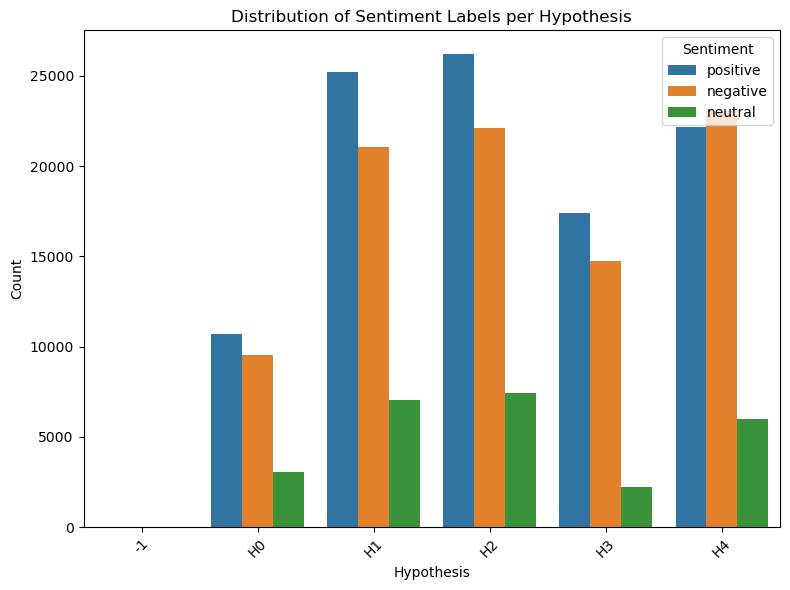

In [57]:
# Plot the distribution of sentiment labels for each hypothesis in a single graph
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='thread_text_hypothesis', hue='sentiment', order=sorted(df['thread_text_hypothesis'].unique()))
plt.title('Distribution of Sentiment Labels per Hypothesis')
plt.xlabel('Hypothesis')
plt.ylabel('Count')
plt.legend(title='Sentiment', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

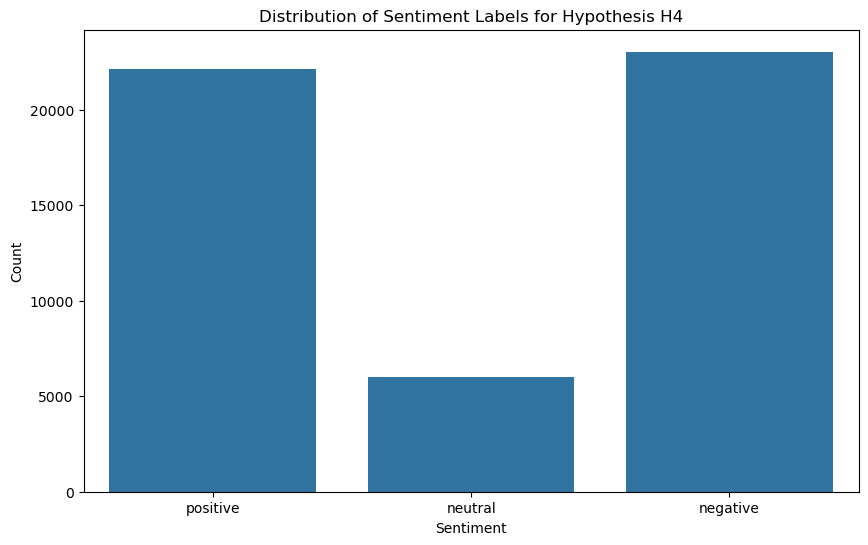

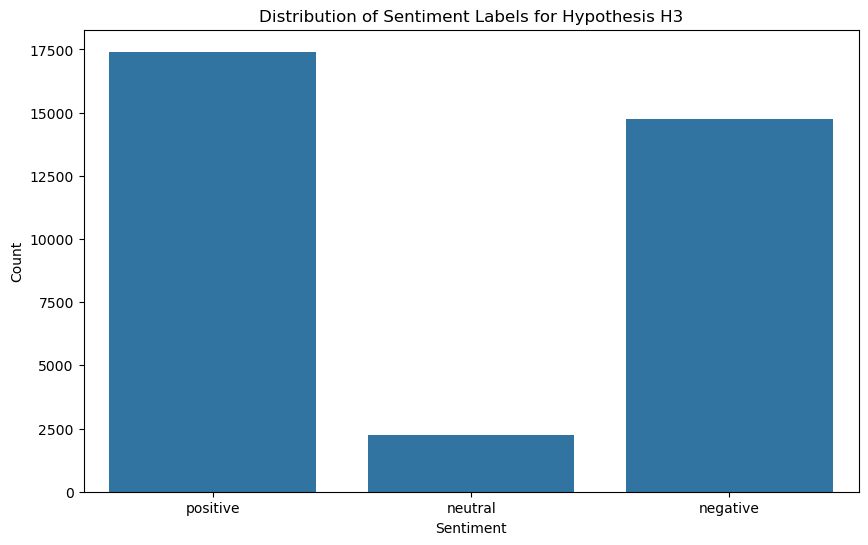

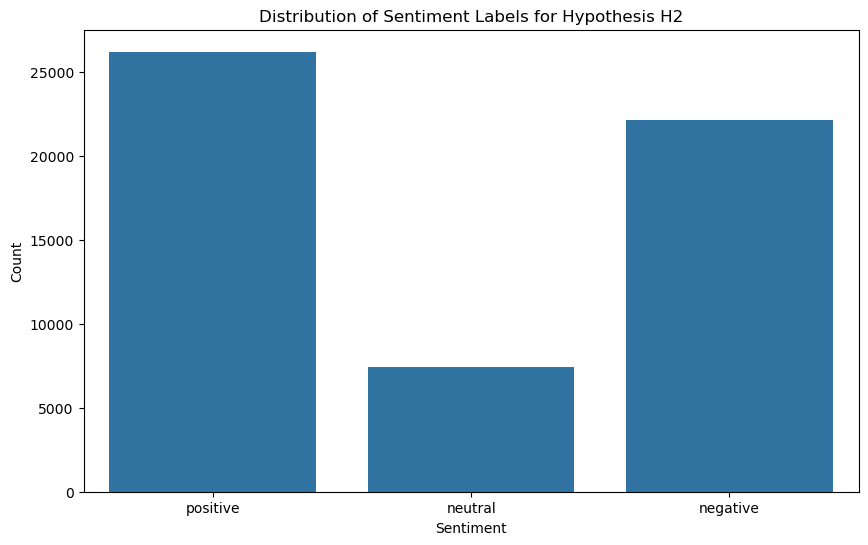

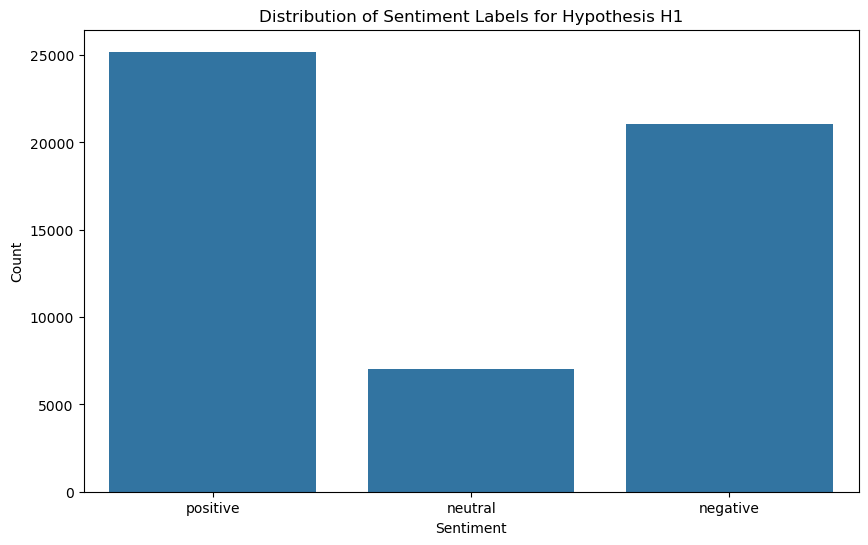

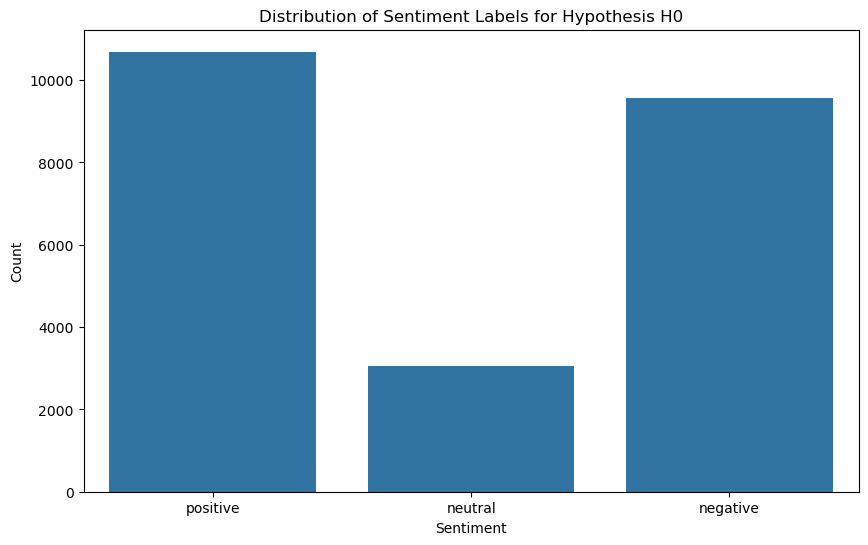

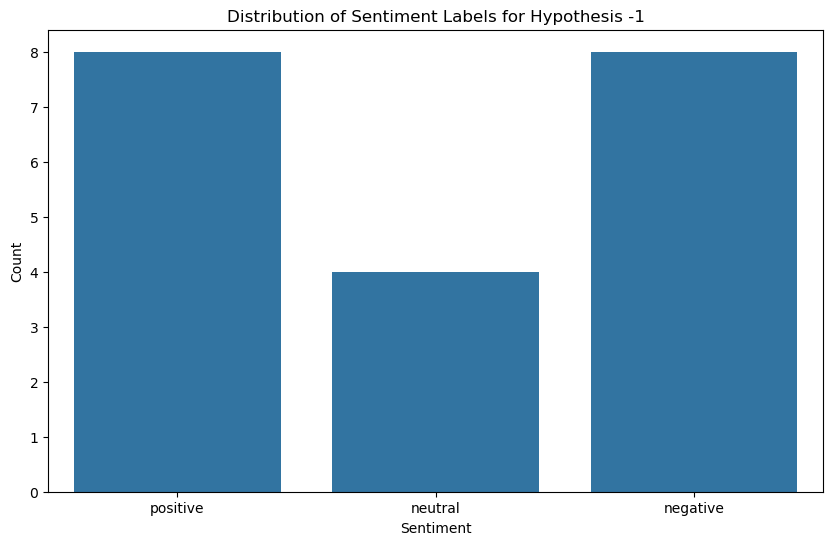

In [53]:
# Get unique hypotheses
hypotheses = df['thread_text_hypothesis'].unique()

# Plot the distribution of sentiment labels for each hypothesis
for hypothesis in hypotheses:
    subset = df[df['thread_text_hypothesis'] == hypothesis]
    plt.figure(figsize=(10, 6))
    sns.countplot(data=subset, x='sentiment', order=['positive', 'neutral', 'negative'])
    plt.title(f'Distribution of Sentiment Labels for Hypothesis {hypothesis}')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

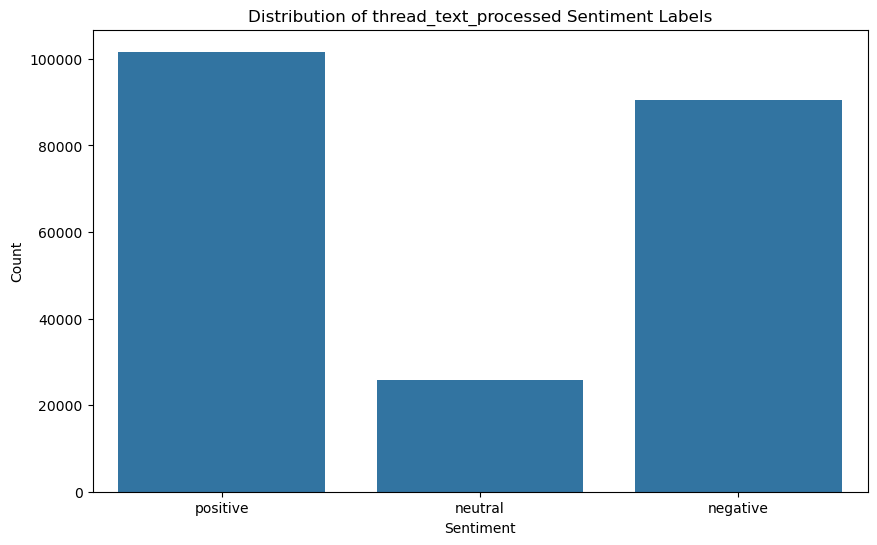

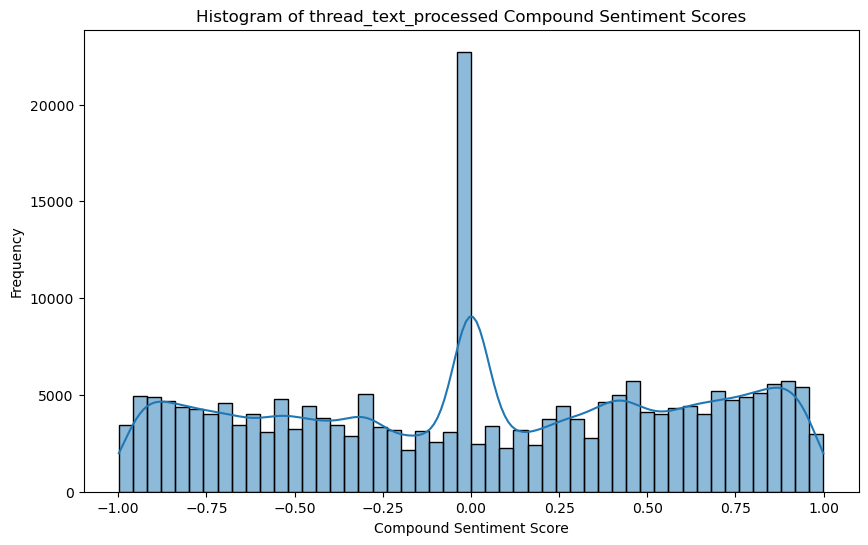

In [50]:
# Plot the distribution of sentiment labels
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment', order=['positive', 'neutral', 'negative'])
plt.title('Distribution of thread_text_processed Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Plot the histogram of compound scores
plt.figure(figsize=(10, 6))
sns.histplot(df['compound'], bins=50, kde=True)
plt.title('Histogram of thread_text_processed Compound Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [52]:
# Display some example rows for each sentiment
positive_examples = df[df['sentiment'] == 'positive'].sample(10)
neutral_examples = df[df['sentiment'] == 'neutral'].sample(10)
negative_examples = df[df['sentiment'] == 'negative'].sample(10)

print("Positive Examples:\n", positive_examples[['thread_text_processed']])
print("\nNeutral Examples:\n", neutral_examples[['thread_text_processed']])
print("\nNegative Examples:\n", negative_examples[['thread_text_processed']])

Positive Examples:
                                     thread_text_processed
76259   say that the combinations are most effective b...
196686  it would be a small fix so the old practice wa...
190965  woe to you dears you cuddled me like a bear bo...
84045   thank you for your efforts sssssss could someo...
107412  laughing twice as his disciple the kovisto its...
45506   this reveals the whole story of a guy being a ...
17242   it occurred to me that googles street view abo...
49799   optical length iso value shutter time and othe...
145227  it is a disease i agree with you that nudity i...
9413    in finland for example there will be substanti...

Neutral Examples:
                                     thread_text_processed
79090   all the same mush today only the butts differ ...
179918  as many people have already known a few days a...
215081  they have got a full job monitoring online wri...
31826   yesterday the speed ranged from to km on the r...
120246  i asked more about the t

In [ ]:
# Plot the distribution of sentiment labels
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='thread_text_processed_sentiment', order=['positive', 'neutral', 'negative'])
plt.title('Distribution of thread_text_processed Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Plot the histogram of compound scores
plt.figure(figsize=(10, 6))
sns.histplot(df['thread_text_processed_compound'], bins=50, kde=True)
plt.title('Histogram of thread_text_processed Compound Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Display some example rows for each sentiment
positive_examples = df[df['thread_text_processed_sentiment'] == 'positive'].sample(5)
neutral_examples = df[df['thread_text_processed_sentiment'] == 'neutral'].sample(5)
negative_examples = df[df['thread_text_processed_sentiment'] == 'negative'].sample(5)

print("Positive Examples:\n", positive_examples[['thread_text_processed', 'thread_text_processed_compound', 'thread_text_processed_sentiment']])
print("\nNeutral Examples:\n", neutral_examples[['thread_text_processed', 'thread_text_processed_compound', 'thread_text_processed_sentiment']])
print("\nNegative Examples:\n", negative_examples[['thread_text_processed', 'thread_text_processed_compound', 'thread_text_processed_sentiment']])

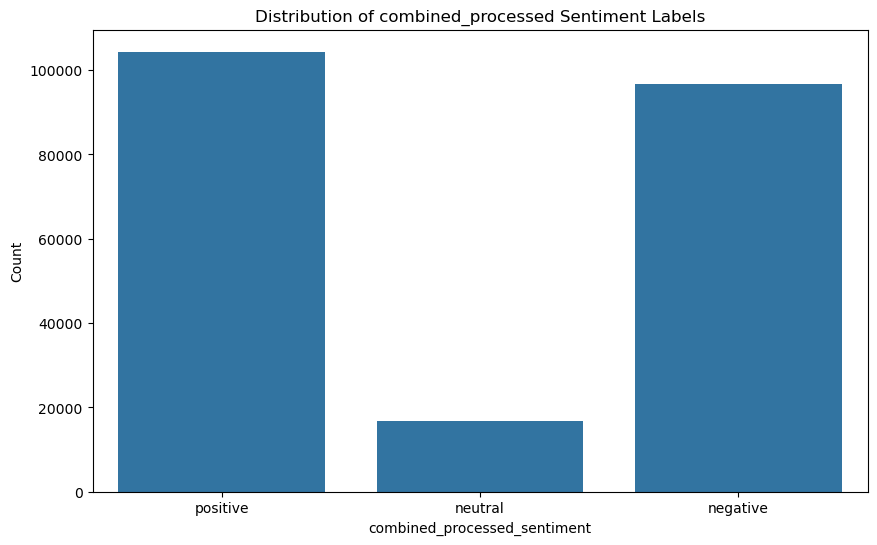

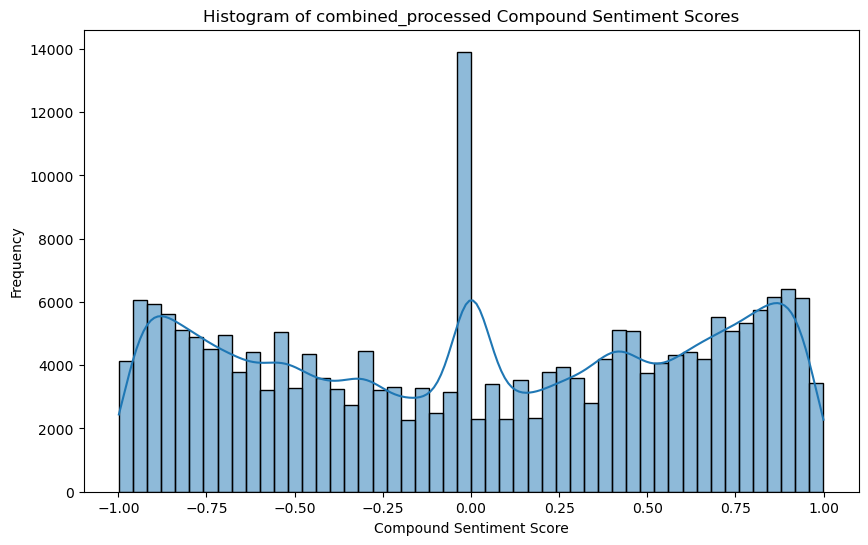

Positive Examples:
                                        combined_processed  \
64270   fuji x or the system or something else science...   
50070   door eye hobbies electronics on the other hand...   
36511   child welfare became a growth business family ...   
204723  whats the gps like vehicles and transport navi...   
93723   kamala family parenthood and whether the girls...   

        combined_processed_compound combined_processed_sentiment  
64270                        0.8720                     positive  
50070                        0.9110                     positive  
36511                        0.3818                     positive  
204723                       0.9758                     positive  
93723                        0.9295                     positive  

Neutral Examples:
                                        combined_processed  \
10786   a church above an individual society catholici...   
130143  police have orders to collect the kajaan money...   
78523   

In [30]:
# Plot the distribution of sentiment labels
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='combined_processed_sentiment', order=['positive', 'neutral', 'negative'])
plt.title('Distribution of combined_processed Sentiment Labels')
plt.xlabel('combined_processed_sentiment')
plt.ylabel('Count')
plt.show()

# Plot the histogram of compound scores
plt.figure(figsize=(10, 6))
sns.histplot(df['combined_processed_compound'], bins=50, kde=True)
plt.title('Histogram of combined_processed Compound Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Display some example rows for each sentiment
positive_examples = df[df['combined_processed_sentiment'] == 'positive'].sample(5)
neutral_examples = df[df['combined_processed_sentiment'] == 'neutral'].sample(5)
negative_examples = df[df['combined_processed_sentiment'] == 'negative'].sample(5)

print("Positive Examples:\n", positive_examples[['combined_processed', 'combined_processed_compound', 'combined_processed_sentiment']])
print("\nNeutral Examples:\n", neutral_examples[['combined_processed', 'combined_processed_compound', 'combined_processed_sentiment']])
print("\nNegative Examples:\n", negative_examples[['combined_processed', 'combined_processed_compound', 'combined_processed_sentiment']])

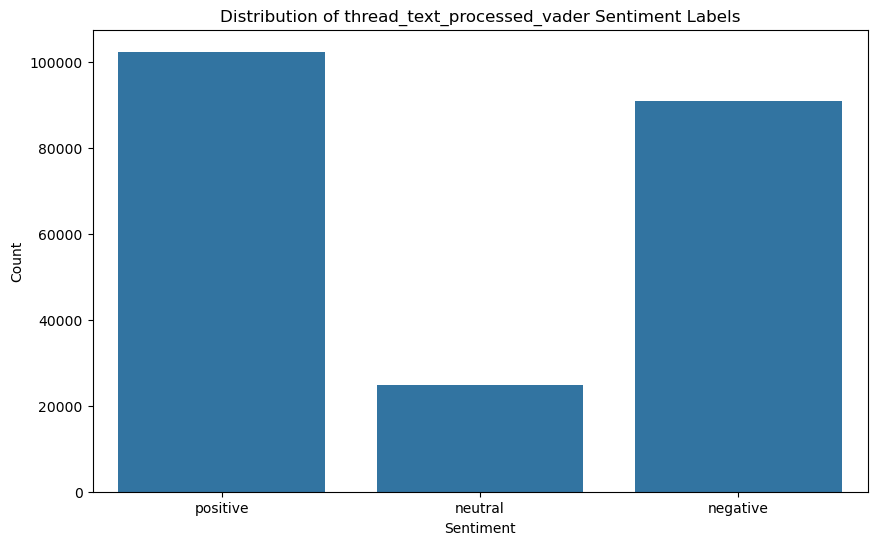

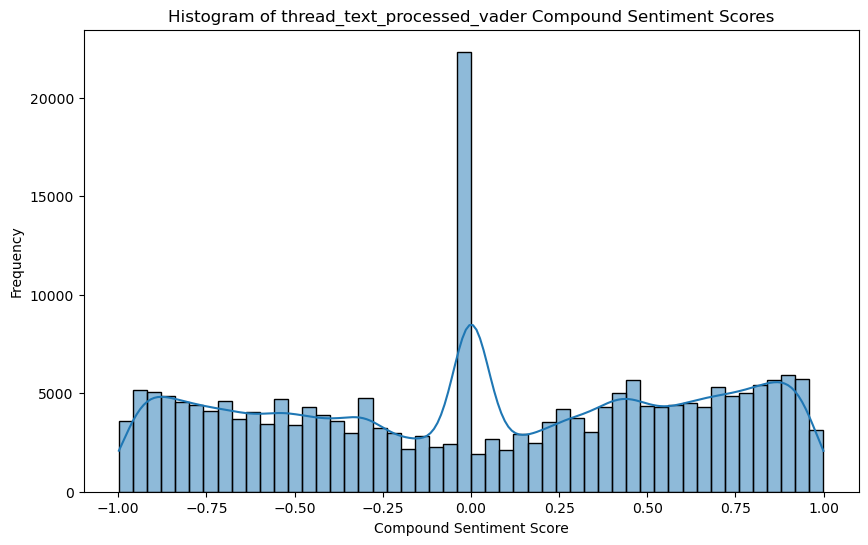

Positive Examples:
                               thread_text_processed_vader  \
210343  i think it is pretty clear to you why people h...   
82467   many people can be in a hurry like that, i. i ...   
102579  as long as you do not now get a decent influen...   
142092  school success may not tell us anything about ...   
78339   and the beak comes into play if the matter is ...   

        thread_text_processed_vader_compound  \
210343                                0.2732   
82467                                 0.7609   
102579                                0.6872   
142092                                0.7783   
78339                                 0.7394   

       thread_text_processed_vader_sentiment  
210343                              positive  
82467                               positive  
102579                              positive  
142092                              positive  
78339                               positive  

Neutral Examples:
                       

In [31]:
# Plot the distribution of sentiment labels
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='thread_text_processed_vader_sentiment', order=['positive', 'neutral', 'negative'])
plt.title('Distribution of thread_text_processed_vader Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Plot the histogram of compound scores
plt.figure(figsize=(10, 6))
sns.histplot(df['thread_text_processed_vader_compound'], bins=50, kde=True)
plt.title('Histogram of thread_text_processed_vader Compound Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Display some example rows for each sentiment
positive_examples = df[df['thread_text_processed_vader_sentiment'] == 'positive'].sample(5)
neutral_examples = df[df['thread_text_processed_vader_sentiment'] == 'neutral'].sample(5)
negative_examples = df[df['thread_text_processed_vader_sentiment'] == 'negative'].sample(5)

print("Positive Examples:\n", positive_examples[['thread_text_processed_vader', 'thread_text_processed_vader_compound', 'thread_text_processed_vader_sentiment']])
print("\nNeutral Examples:\n", neutral_examples[['thread_text_processed_vader', 'thread_text_processed_vader_compound', 'thread_text_processed_vader_sentiment']])
print("\nNegative Examples:\n", negative_examples[['thread_text_processed_vader', 'thread_text_processed_vader_compound', 'thread_text_processed_vader_sentiment']])

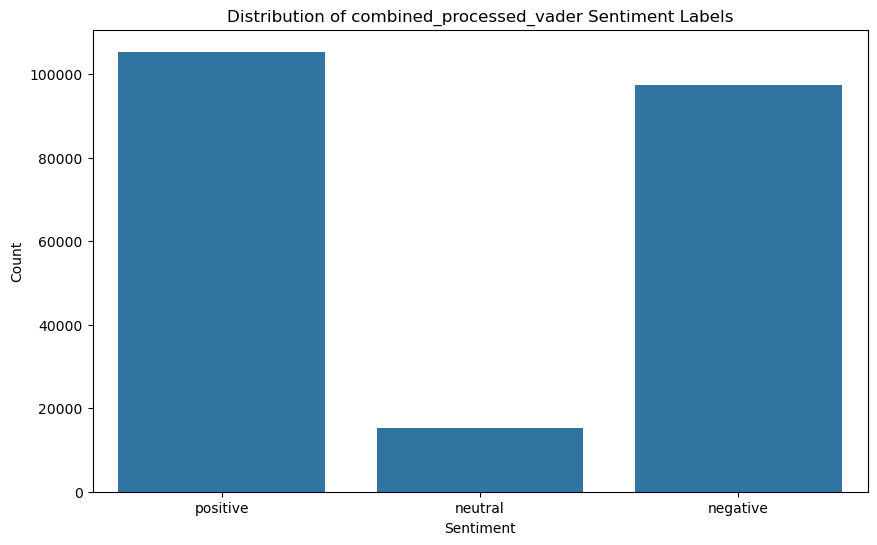

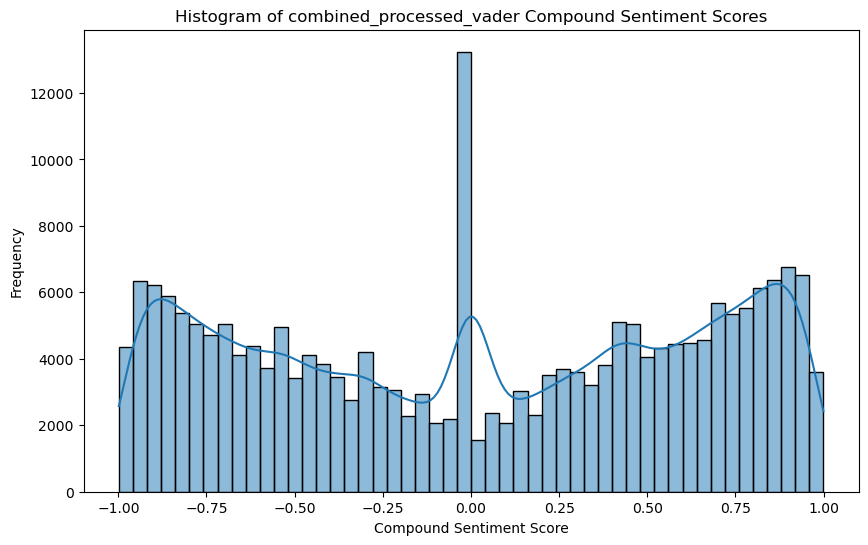

Positive Examples:
                                  combined_processed_vader  \
22896   arson society mormonism i know that the map or...   
181603  the watchman at the business center? society s...   
143845  security camera science and technology general...   
206748  where do not you want to go the second time? g...   
131463  powershot gx science and technology canon a th...   

        combined_processed_vader_compound combined_processed_vader_sentiment  
22896                              0.2023                           positive  
181603                             0.2168                           positive  
143845                             0.5859                           positive  
206748                             0.7413                           positive  
131463                             0.4404                           positive  

Neutral Examples:
                                  combined_processed_vader  \
105427  live as you preach. science and technology sys... 

In [32]:
# Plot the distribution of sentiment labels
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='combined_processed_vader_sentiment', order=['positive', 'neutral', 'negative'])
plt.title('Distribution of combined_processed_vader Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Plot the histogram of compound scores
plt.figure(figsize=(10, 6))
sns.histplot(df['combined_processed_vader_compound'], bins=50, kde=True)
plt.title('Histogram of combined_processed_vader Compound Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Display some example rows for each sentiment
positive_examples = df[df['combined_processed_vader_sentiment'] == 'positive'].sample(5)
neutral_examples = df[df['combined_processed_vader_sentiment'] == 'neutral'].sample(5)
negative_examples = df[df['combined_processed_vader_sentiment'] == 'negative'].sample(5)

print("Positive Examples:\n", positive_examples[['combined_processed_vader', 'combined_processed_vader_compound', 'combined_processed_vader_sentiment']])
print("\nNeutral Examples:\n", neutral_examples[['combined_processed_vader', 'combined_processed_vader_compound', 'combined_processed_vader_sentiment']])
print("\nNegative Examples:\n", negative_examples[['combined_processed_vader', 'combined_processed_vader_compound', 'combined_processed_vader_sentiment']])